In [1]:
from keras import applications
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.vgg19 import preprocess_input
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

Using TensorFlow backend.


# Import des données

In [2]:
data_dir = "Images/"
img_width = 200
img_height = 200
batch_sz = 35

In [3]:
datagen = ImageDataGenerator(
            rescale = None,
            horizontal_flip = True,
            fill_mode = "nearest",
            zoom_range = 0.3,
            width_shift_range = 0.3,
            height_shift_range = 0.3,
            rotation_range = 30,
            validation_split = 0.3,
            preprocessing_function = preprocess_input)

In [4]:
train_generator = datagen.flow_from_directory(
                        data_dir,
                        target_size = (img_width, img_height),
                        class_mode = "categorical",
                        subset = 'training',
                        batch_size = batch_sz)

Found 1830 images belonging to 15 classes.


In [5]:
test_generator = datagen.flow_from_directory(
                        data_dir,
                        target_size = (img_width, img_height),
                        class_mode = "categorical",
                        subset = 'validation',
                        batch_size = batch_sz)

Found 777 images belonging to 15 classes.


In [6]:
nb_classes = len(train_generator.class_indices)

# Construction du CNN

In [7]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [196]:
#freeze all layers
for layer in model.layers:
   layer.trainable = False

In [197]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(rate=0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(nb_classes, activation="softmax")(x)

In [198]:
# creating the final model 
model_final = Model(input = model.input, output = predictions)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [199]:
# compile the model 
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, 
                                               momentum=0.9), metrics=["accuracy"])

In [200]:
history = model_final.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_sz,
    validation_data = test_generator, 
    validation_steps = test_generator.samples // batch_sz,
    epochs = 100)

Epoch 1/100
52/52 [==============================] - 866s 17s/step - loss: 11.6790 - acc: 0.1610 - val_loss: 7.7468 - val_acc: 0.3481
Epoch 2/100
52/52 [==============================] - 843s 16s/step - loss: 8.4369 - acc: 0.3402 - val_loss: 5.6598 - val_acc: 0.5189
Epoch 3/100
52/52 [==============================] - 841s 16s/step - loss: 6.8522 - acc: 0.4486 - val_loss: 5.0286 - val_acc: 0.5566
Epoch 4/100
52/52 [==============================] - 844s 16s/step - loss: 5.8730 - acc: 0.5044 - val_loss: 4.1422 - val_acc: 0.6199
Epoch 5/100
52/52 [==============================] - 846s 16s/step - loss: 5.2625 - acc: 0.5484 - val_loss: 3.9712 - val_acc: 0.6294
Epoch 6/100
52/52 [==============================] - 846s 16s/step - loss: 4.9190 - acc: 0.5778 - val_loss: 3.9035 - val_acc: 0.6563
Epoch 7/100
52/52 [==============================] - 844s 16s/step - loss: 4.7284 - acc: 0.5995 - val_loss: 3.5407 - val_acc: 0.6631
Epoch 8/100
52/52 [==============================] - 845s 16s/step -

In [213]:
# Save Weights
model_final.save('model_final.h5')
model_final.save_weights('model_final_weights.h5')

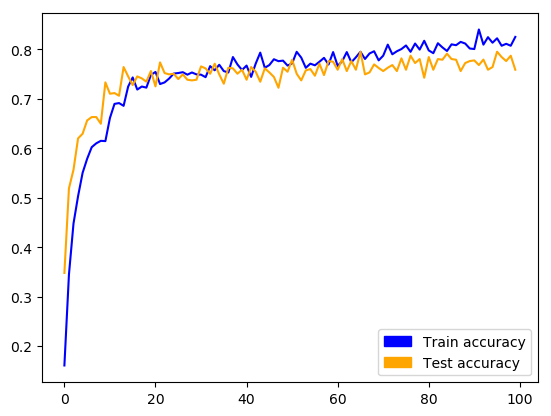

In [208]:
# plot metrics
plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['val_acc'], color='orange')
train_patch = mpatches.Patch(color='blue', label='Train accuracy')
test_patch = mpatches.Patch(color='orange', label='Test accuracy')
plt.legend(handles=[train_patch, test_patch])

# Résultats

In [203]:
def barh_results(y, acc_train, acc_test):
    df = pd.DataFrame(dict(graph=y,
                           n=acc_train, m=acc_test)) 

    ind = np.arange(len(df))
    width = 0.4

    fig, ax = plt.subplots()
    ax.barh(ind, df.n, width, color='red', label='Train')
    ax.barh(ind + width, df.m, width, color='blue', label='Test')

    ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
    ax.legend()

    plt.show()

In [276]:
def compute_results(generator, model):   
    #prediction
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit([[a] for a in range(0, nb_classes)])
    
    generator.reset()
    batch_index = 0
    y = []
    y_pred = []
    while batch_index <= generator.batch_index:
        data = generator.next()
        y.append(enc.inverse_transform(data[1]))
        y_pred.append(model.predict(data[0]).argmax(axis=-1))
        batch_index = batch_index + 1
    
    y = [a[0] for b in y for a in b]
    y_pred = [a[i] for a in y_pred for i in range(0, len(a))]
    
    #score
    df = pd.DataFrame({'y': y})
    df['y_pred'] = y_pred
    score = []
    categories = list(set(y))
    for c in categories:
        s = accuracy_score(df.loc[df['y'] == c, 'y'], df.loc[df['y'] == c, 'y_pred'])
        score.append(s)
        
    return score

In [205]:
model_final.get_config('model_final.h5')
model_final.load_weights('model_final_weights.h5', by_name=False)

AttributeError: 'Model' object has no attribute 'load'

In [209]:
train_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02088632-bluetick': 6,
 'n02091032-Italian_greyhound': 7,
 'n02099601-golden_retriever': 8,
 'n02102973-Irish_water_spaniel': 9,
 'n02107142-Doberman': 10,
 'n02109961-Eskimo_dog': 11,
 'n02110063-malamute': 12,
 'n02113023-Pembroke': 13,
 'n02113712-miniature_poodle': 14}

In [258]:
score_test = compute_results(test_generator, model_final)

In [277]:
score_train = compute_results(train_generator, model_final)

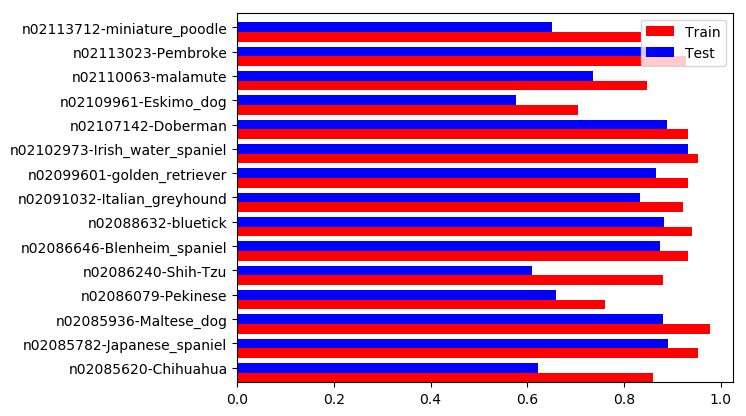

In [278]:
barh_results(list(train_generator.class_indices.keys()), score_train, score_test)